In [1]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm > /dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
# -------------------------
# 1) Konfigurasi path & unduh ZIP
# -------------------------
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu) #https://drive.google.com/file/d/1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA/view?usp=sharing
# https://drive.google.com/file/d/1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA/view?usp=drive_link
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex")    # root ekstraksi

SAVE_DIR = Path("/content/drive/MyDrive/dataset_mirex/miditrainsvm")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

Downloading...
From (original): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA
From (redirected): https://drive.google.com/uc?id=1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA&confirm=t&uuid=cb33c256-cfc3-41cc-985d-7f4a0787a72d
To: /content/dataset_mirex.zip
100%|██████████| 320M/320M [00:02<00:00, 127MB/s]


Extracting ZIP ...


In [3]:
# -------------------------
# 2) Deteksi folder internal (menyesuaikan struktur di screenshot)
#    target kita: <ROOT>/dataset/{Audio, Lyrics, MIDIs, ...}
# -------------------------
ROOT = EXTRACT_DIR
# kalau di dalam ada folder "dataset", pakai itu
if (EXTRACT_DIR / "dataset").exists():
    ROOT = EXTRACT_DIR / "dataset"

AUDIO_DIR = ROOT / "Audio"
LYRIC_DIR = ROOT / "Lyrics"
MIDI_DIR  = ROOT / "MIDIs"

# file .bat yang ada (bisa lebih dari satu: audio, lyrics, midi)
BAT_FILES = sorted(list(ROOT.glob("split-by-categories*.bat")))

print("ROOT:", ROOT)
print("AUDIO_DIR:", AUDIO_DIR.exists(), AUDIO_DIR)
print("LYRIC_DIR:", LYRIC_DIR.exists(), LYRIC_DIR)
print("MIDI_DIR :", MIDI_DIR.exists(),  MIDI_DIR)
print("BAT_FILES:", [b.name for b in BAT_FILES])

ROOT: /content/dataset_mirex/dataset
AUDIO_DIR: True /content/dataset_mirex/dataset/Audio
LYRIC_DIR: True /content/dataset_mirex/dataset/Lyrics
MIDI_DIR : True /content/dataset_mirex/dataset/MIDIs
BAT_FILES: ['split-by-categories-audio.bat', 'split-by-categories-lyrics.bat', 'split-by-categories-midi.bat']


In [4]:

# -------------------------
# 3) Parsing label dari .bat
#    Format contoh:
#    move 001.mp3 "Cluster 1\Boisterous\001.mp3"
#    move 002.txt "Cluster 2\Calm\002.txt"
#    move 003.mid "Cluster 5\Visceral\003.mid"
# -------------------------
def parse_bat_labels(bat_path: Path):
    """
    Return DataFrame: file_id, ext, cluster, subcat, label_cluster, label_full
    """
    rows = []
    pat = re.compile(r'move\s+(\d+)\.(mp3|txt|mid)\s+"([^\\]+)\\([^\\]+)\\.*"', re.IGNORECASE)
    with open(bat_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            m = pat.search(line.strip())
            if m:
                fid, ext, cluster, subcat = m.group(1), m.group(2).lower(), m.group(3), m.group(4)
                rows.append({
                    "file_id": f"{int(fid):03d}",     # normalisasi 3 digit
                    "ext": ext,
                    "cluster": cluster.strip(),        # e.g., "Cluster 1"
                    "subcat": subcat.strip(),          # e.g., "Boisterous"
                    "label_cluster": cluster.strip(),
                    "label_full": f"{cluster.strip()} / {subcat.strip()}",
                })
    return pd.DataFrame(rows)

labels_all_df = pd.DataFrame(columns=["file_id","ext","cluster","subcat","label_cluster","label_full"])
for bat in BAT_FILES:
    df = parse_bat_labels(bat)
    if not df.empty:
        labels_all_df = pd.concat([labels_all_df, df], ignore_index=True)

# deduplicate jika dobel
labels_all_df = labels_all_df.drop_duplicates(subset=["file_id","ext","label_full"])

# Sediakan peta label "utama" per file_id (prioritas: audio -> lyrics -> midi)
# kita pakai label_cluster (Cluster 1..5) sebagai label utama untuk plotting
def pick_main_label(g):
    # prioritas ext: mp3 > txt > mid
    order = {"mp3":0, "txt":1, "mid":2}
    g2 = g.copy()
    g2["prio"] = g2["ext"].map(order).fillna(99)
    row = g2.sort_values(["prio"]).iloc[0]
    return pd.Series({"label_cluster": row["label_cluster"], "label_full": row["label_full"]})

main_labels = labels_all_df.groupby("file_id").apply(pick_main_label).reset_index()

print(f"Parsed labels from BAT: {len(labels_all_df)} lines | unique file IDs with labels: {len(main_labels)}")
display(main_labels.head(10))

Parsed labels from BAT: 2709 lines | unique file IDs with labels: 903


/tmp/ipython-input-1204951292.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  main_labels = labels_all_df.groupby("file_id").apply(pick_main_label).reset_index()


,file_id,label_cluster,label_full
0,001,Cluster 1,Cluster 1 / Boisterous
1,002,Cluster 1,Cluster 1 / Boisterous
2,003,Cluster 1,Cluster 1 / Boisterous
3,004,Cluster 1,Cluster 1 / Boisterous
4,005,Cluster 1,Cluster 1 / Boisterous
5,006,Cluster 1,Cluster 1 / Boisterous
6,007,Cluster 1,Cluster 1 / Boisterous
7,008,Cluster 1,Cluster 1 / Boisterous
8,009,Cluster 1,Cluster 1 / Boisterous
9,010,Cluster 1,Cluster 1 / Boisterous


In [5]:
# -------------------------
# 4) Inventaris file per modalitas (tanpa subfolder label)
# -------------------------
def list_files(dir_path: Path, exts):
    files = []
    if dir_path.exists():
        for ext in exts:
            for p in dir_path.glob(f"*.{ext}"):
                files.append(p)
    return sorted(files)

audio_files = list_files(AUDIO_DIR, ["mp3","wav"])   # datasetmu mp3
lyric_files = list_files(LYRIC_DIR, ["txt"])
midi_files  = list_files(MIDI_DIR,  ["mid"])

def to_df(files, kind):
    rows = []
    for p in files:
        fid = re.sub(r"\.[^.]+$","", p.name)  # nama tanpa ekstensi
        rows.append({"file_id": fid, "path": str(p), "modality": kind})
    return pd.DataFrame(rows)

audio_df = to_df(audio_files, "audio")
lyric_df = to_df(lyric_files, "lyrics")
midi_df  = to_df(midi_files,  "midi")

print("Counts — audio/lyrics/midi:", len(audio_df), len(lyric_df), len(midi_df))

Counts — audio/lyrics/midi: 903 764 196


In [6]:
# -------------------------
# 5) Alignment tabel antar modalitas
#    label utama diambil dari 'main_labels' (fallback jika ada)
# -------------------------
# normalisasi file_id ke 3 digit bila perlu (001, 002, ...)
def norm_id(s):
    try:
        return f"{int(s):03d}"
    except:
        return s

for df in (audio_df, lyric_df, midi_df):
    df["file_id_norm"] = df["file_id"].apply(norm_id)

# join label
audio_df = audio_df.merge(main_labels, left_on="file_id_norm", right_on="file_id", how="left", suffixes=("","_lbl"))
lyric_df = lyric_df.merge(main_labels, left_on="file_id_norm", right_on="file_id", how="left", suffixes=("","_lbl"))
midi_df  = midi_df.merge(main_labels, left_on="file_id_norm", right_on="file_id", how="left", suffixes=("","_lbl"))

# alignment
all_ids = sorted(set(audio_df["file_id_norm"]) | set(lyric_df["file_id_norm"]) | set(midi_df["file_id_norm"]))
rows = []
for fid in all_ids:
    rows.append({
        "file_id": fid,
        "has_audio": fid in set(audio_df["file_id_norm"]),
        "has_lyrics": fid in set(lyric_df["file_id_norm"]),
        "has_midi": fid in set(midi_df["file_id_norm"]),
        "label_cluster": main_labels.set_index("file_id").get("label_cluster").get(fid, None),
        "label_full": main_labels.set_index("file_id").get("label_full").get(fid, None),
    })
align_df = pd.DataFrame(rows)

# ringkas coverage
coverage = {
    "total_unique_ids": len(all_ids),
    "all_three": int(((align_df["has_audio"]) & (align_df["has_lyrics"]) & (align_df["has_midi"])).sum()),
    "audio_only": int(((align_df["has_audio"]) & (~align_df["has_lyrics"]) & (~align_df["has_midi"])).sum()),
    "lyrics_only": int(((~align_df["has_audio"]) & (align_df["has_lyrics"]) & (~align_df["has_midi"])).sum()),
    "midi_only": int(((~align_df["has_audio"]) & (~align_df["has_lyrics"]) & (align_df["has_midi"])).sum()),
}

print("\n=== ALIGNMENT SUMMARY ===")
print(coverage)
display(align_df.head(10))

# Simpan hasil penting
main_labels.to_csv(SAVE_DIR / "labels_main_from_bat.csv", index=False)
align_df.to_csv(SAVE_DIR / "alignment_audio_lyrics_midi.csv", index=False)
print("\nSaved to:", SAVE_DIR)


=== ALIGNMENT SUMMARY ===
{'total_unique_ids': 903, 'all_three': 193, 'audio_only': 136, 'lyrics_only': 0, 'midi_only': 0}


,file_id,has_audio,has_lyrics,has_midi,label_cluster,label_full
0,001,True,True,False,Cluster 1,Cluster 1 / Boisterous
1,002,True,False,False,Cluster 1,Cluster 1 / Boisterous
2,003,True,True,False,Cluster 1,Cluster 1 / Boisterous
3,004,True,True,True,Cluster 1,Cluster 1 / Boisterous
4,005,True,False,False,Cluster 1,Cluster 1 / Boisterous
5,006,True,False,False,Cluster 1,Cluster 1 / Boisterous
6,007,True,True,False,Cluster 1,Cluster 1 / Boisterous
7,008,True,True,True,Cluster 1,Cluster 1 / Boisterous
8,009,True,True,True,Cluster 1,Cluster 1 / Boisterous
9,010,True,True,False,Cluster 1,Cluster 1 / Boisterous



Saved to: /content/drive/MyDrive/dataset_mirex/miditrainsvm


In [7]:
# -------------------------
# 6) Siapkan subset MIDI + label
# -------------------------
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

!pip install pretty_midi -q
import pretty_midi

# kalau align_df belum punya kolom label_full / label_cluster, merge lagi dengan main_labels
if "label_full" not in align_df.columns or "label_cluster" not in align_df.columns:
    align_df = align_df.merge(
        main_labels[["file_id", "label_cluster", "label_full"]],
        on="file_id",
        how="left"
    )

# filter: punya MIDI + label
midi_meta = align_df[
    (align_df["has_midi"] == True) &
    (align_df["label_cluster"].notnull())
].copy()

# path midi: asumsi 001.mid dst
def midi_path_from_id(fid):
    return MIDI_DIR / f"{fid}.mid"

midi_meta["midi_path"] = midi_meta["file_id"].apply(midi_path_from_id)
midi_meta["exists"] = midi_meta["midi_path"].apply(lambda p: p.is_file())
midi_meta = midi_meta[midi_meta["exists"]].copy()

print("Jumlah sampel MIDI terpakai:", len(midi_meta))
midi_meta.head()


Jumlah sampel MIDI terpakai: 196


,file_id,has_audio,has_lyrics,has_midi,label_cluster,label_full,midi_path,exists
3,004,True,True,True,Cluster 1,Cluster 1 / Boisterous,/content/dataset_mirex/dataset/MIDIs/004.mid,True
7,008,True,True,True,Cluster 1,Cluster 1 / Boisterous,/content/dataset_mirex/dataset/MIDIs/008.mid,True
8,009,True,True,True,Cluster 1,Cluster 1 / Boisterous,/content/dataset_mirex/dataset/MIDIs/009.mid,True
11,012,True,True,True,Cluster 1,Cluster 1 / Boisterous,/content/dataset_mirex/dataset/MIDIs/012.mid,True
18,019,True,True,True,Cluster 1,Cluster 1 / Boisterous,/content/dataset_mirex/dataset/MIDIs/019.mid,True


label_cluster
Cluster 3    48
Cluster 1    45
Cluster 2    45
Cluster 4    33
Cluster 5    25
Name: count, dtype: int64


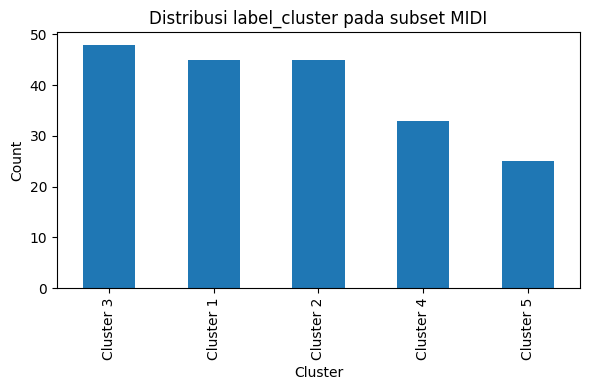

/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error parsing /content/dataset_mirex/dataset/MIDIs/009.mid : data byte must be in range 0..127
Error parsing /content/dataset_mirex/dataset/MIDIs/097.mid : data byte must be in range 0..127
count      196.000000
mean      5184.765306
std       2971.225429
min          0.000000
25%       3497.750000
50%       4570.500000
75%       6512.000000
max      28489.000000
Name: num_notes, dtype: float64


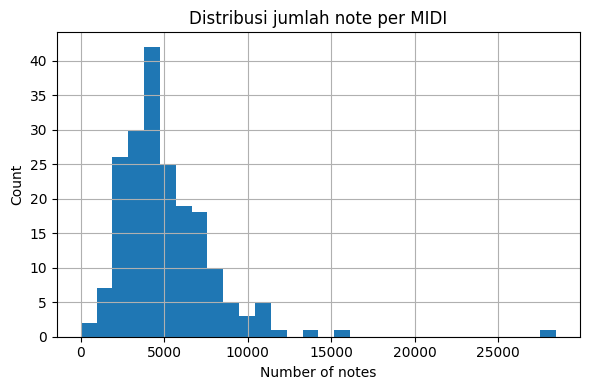

In [8]:
# -------------------------
# 7) EDA untuk MIDI
# -------------------------

# 7.1 Distribusi kelas (pakai label_cluster dulu; nanti bisa kamu map ke aggressive/cheerful dst)
label_counts = midi_meta["label_cluster"].value_counts()
print(label_counts)

plt.figure(figsize=(6,4))
label_counts.plot(kind="bar")
plt.title("Distribusi label_cluster pada subset MIDI")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7.2 Jumlah note per file (buat gambaran kompleksitas)
def count_notes(path):
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
        total_notes = sum(len(inst.notes) for inst in pm.instruments)
        return total_notes
    except Exception as e:
        print("Error parsing", path, ":", e)
        return 0

midi_meta["num_notes"] = midi_meta["midi_path"].apply(count_notes)
print(midi_meta["num_notes"].describe())

plt.figure(figsize=(6,4))
midi_meta["num_notes"].hist(bins=30)
plt.xlabel("Number of notes")
plt.ylabel("Count")
plt.title("Distribusi jumlah note per MIDI")
plt.tight_layout()
plt.show()


In [9]:
# install dependencies untuk audio synth
!apt-get install -y fluidsynth > /dev/null
!pip install pyfluidsynth -q


Extracting templates from packages: 100%


In [10]:
# ===== 8.1 — BUILD df_midi_eda UNTUK EDA MIDI =====
import numpy as np, pandas as pd
from pathlib import Path

# Pastikan midi_df & align_df sudah ada
assert "midi_df" in globals() and not midi_df.empty, "midi_df belum ada."
assert "align_df" in globals() and not align_df.empty, "align_df belum ada."

# midi_df: [file_id, path, modality, file_id_norm]
# align_df: [file_id, has_audio, has_lyrics, has_midi, label_cluster, label_full]

# Gabungkan info label ke midi_df
df_midi_eda = midi_df.merge(
    align_df[["file_id", "label_cluster", "label_full"]],
    left_on="file_id_norm",
    right_on="file_id",
    how="left",
    suffixes=("", "_aln")
)

# ===== (Opsional) mapping Cluster -> 5 emosi utama =====
# Kalau kamu sudah punya mapping, isi di sini:
# misal:
# CLUSTER_TO_EMOTION = {
#     "Cluster 1": "aggressive",
#     "Cluster 2": "cheerful",
#     "Cluster 3": "humorous",
#     "Cluster 4": "passionate",
#     "Cluster 5": "wistful",
# }
CLUSTER_TO_EMOTION = None  # ganti kalau sudah ada

if CLUSTER_TO_EMOTION is not None:
    df_midi_eda["emotion"] = df_midi_eda["label_cluster"].map(CLUSTER_TO_EMOTION)
else:
    # Fallback: pakai label_cluster langsung sebagai "emotion"
    df_midi_eda["emotion"] = df_midi_eda["label_cluster"]

print("df_midi_eda shape:", df_midi_eda.shape)
df_midi_eda.head()


df_midi_eda shape: (196, 11)


,file_id,path,modality,file_id_norm,file_id_lbl,label_cluster,label_full,file_id_aln,label_cluster_aln,label_full_aln,emotion
0,004,/content/dataset_mirex/dataset/MIDIs/004.mid,midi,004,004,Cluster 1,Cluster 1 / Boisterous,004,Cluster 1,Cluster 1 / Boisterous,Cluster 1
1,008,/content/dataset_mirex/dataset/MIDIs/008.mid,midi,008,008,Cluster 1,Cluster 1 / Boisterous,008,Cluster 1,Cluster 1 / Boisterous,Cluster 1
2,009,/content/dataset_mirex/dataset/MIDIs/009.mid,midi,009,009,Cluster 1,Cluster 1 / Boisterous,009,Cluster 1,Cluster 1 / Boisterous,Cluster 1
3,012,/content/dataset_mirex/dataset/MIDIs/012.mid,midi,012,012,Cluster 1,Cluster 1 / Boisterous,012,Cluster 1,Cluster 1 / Boisterous,Cluster 1
4,019,/content/dataset_mirex/dataset/MIDIs/019.mid,midi,019,019,Cluster 1,Cluster 1 / Boisterous,019,Cluster 1,Cluster 1 / Boisterous,Cluster 1


In [11]:
# ===== 8.2 — IMPORT & SETUP VISUAL =====
!pip install librosa seaborn -q

import pretty_midi
import librosa.display as ldisplay
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


== PREVIEW MIDI ==  Label: Cluster 1 | ID: 138
- Label_full: Cluster 1 / Rousing
- Durasi: 121.11s | Tempo(mean): 81.0 BPM | Instrumen: 5
- Avg Pitch: 52.8 (C4=60) | Pitch Range: 45.0
- Cara baca:
  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.
  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.
  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).



/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


== PREVIEW MIDI ==  Label: Cluster 2 | ID: 180
- Label_full: Cluster 2 / Amiable-good natured
- Durasi: 270.57s | Tempo(mean): 158.8 BPM | Instrumen: 11
- Avg Pitch: 52.4 (C4=60) | Pitch Range: 63.0
- Cara baca:
  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.
  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.
  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).

== PREVIEW MIDI ==  Label: Cluster 3 | ID: 549
- Label_full: Cluster 3 / Wistful
- Durasi: 177.68s | Tempo(mean): 73.0 BPM | Instrumen: 15
- Avg Pitch: 56.7 (C4=60) | Pitch Range: 60.0
- Cara baca:
  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.
  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.
  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).



/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


== PREVIEW MIDI ==  Label: Cluster 4 | ID: 552
- Label_full: Cluster 4 / Campy
- Durasi: 197.47s | Tempo(mean): 103.7 BPM | Instrumen: 10
- Avg Pitch: 63.1 (C4=60) | Pitch Range: 48.0
- Cara baca:
  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.
  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.
  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).



/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


== PREVIEW MIDI ==  Label: Cluster 5 | ID: 838
- Label_full: Cluster 5 / Tense - Anxious
- Durasi: 275.95s | Tempo(mean): 121.4 BPM | Instrumen: 9
- Avg Pitch: 55.0 (C4=60) | Pitch Range: 62.0
- Cara baca:
  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.
  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.
  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).



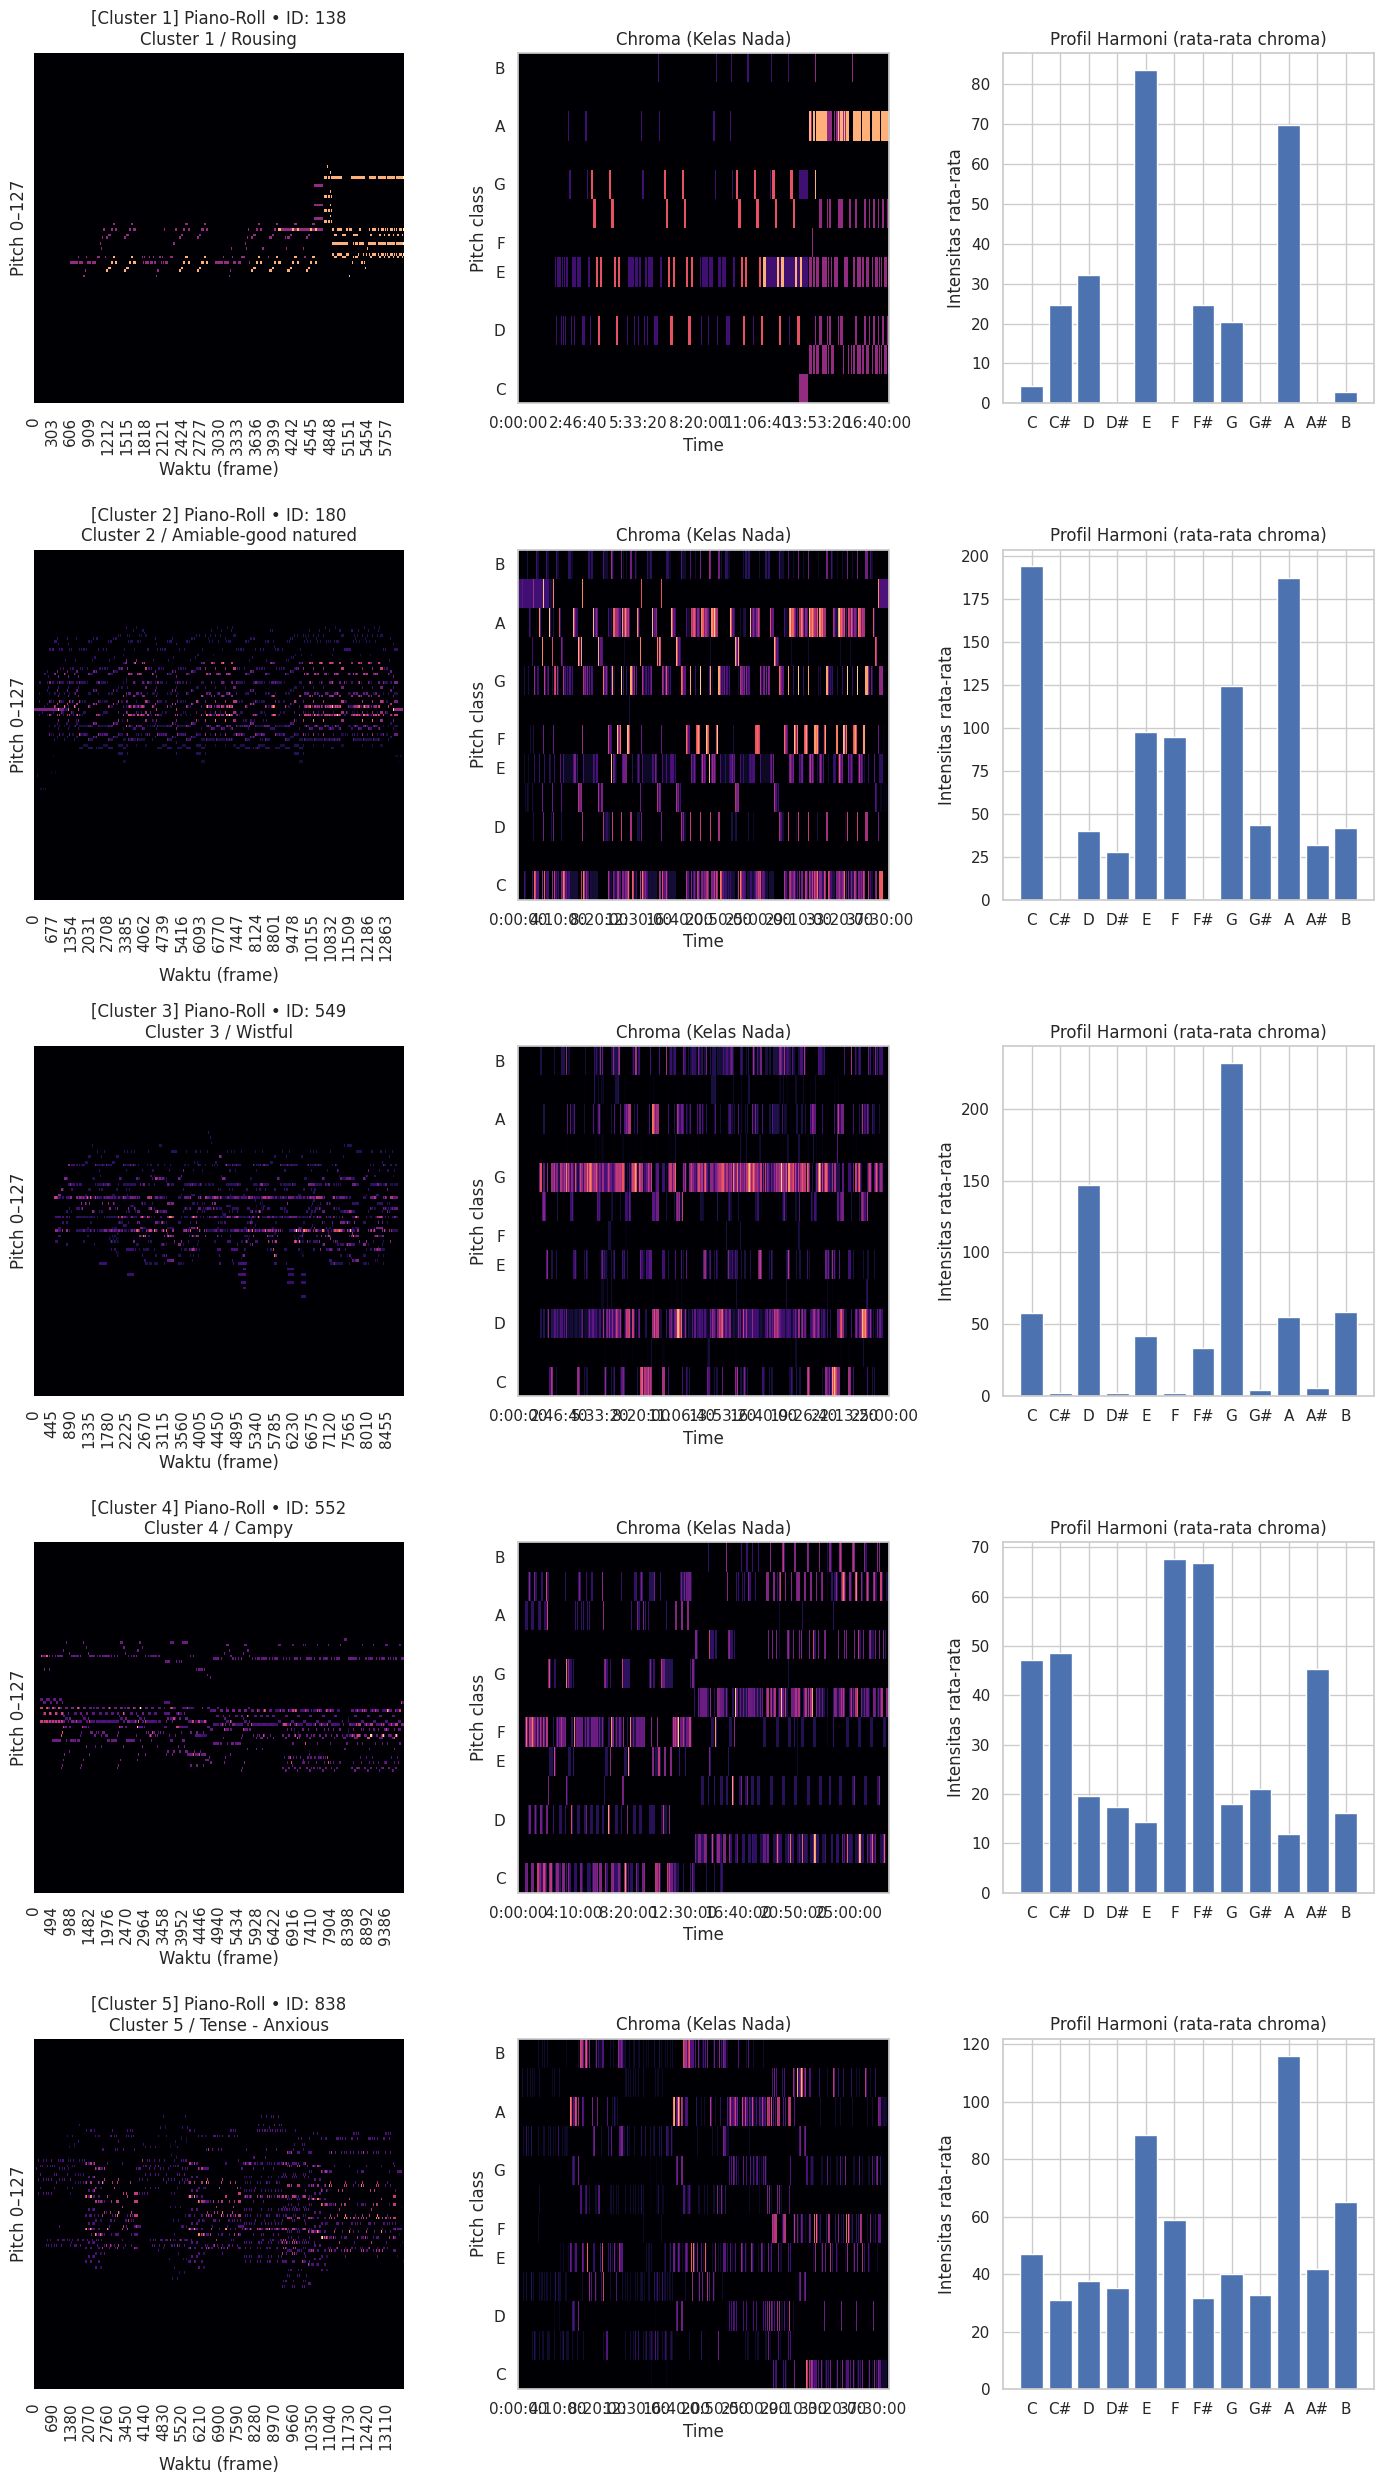

In [12]:
# ===== 8.3 — MIDI PREVIEW PER LABEL =====
N_PER_LABEL = 1      # berapa sampel per label untuk preview
FS_VIS      = 50     # resolusi visual (frame per detik) untuk piano-roll & chroma
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# pastikan df_midi_eda & kolom 'emotion' ada
assert "df_midi_eda" in globals() and not df_midi_eda.empty, "df_midi_eda belum dibuat (6C.1)."
assert "emotion" in df_midi_eda.columns, "df_midi_eda belum punya kolom 'emotion'."

preview_ids = []
for lbl in sorted(df_midi_eda["emotion"].dropna().unique()):
    subset = df_midi_eda[df_midi_eda["emotion"] == lbl]["file_id_norm"].dropna().unique()
    if len(subset) == 0:
        continue
    take = min(N_PER_LABEL, len(subset))
    choice = np.random.choice(subset, size=take, replace=False)
    preview_ids.extend([(lbl, fid) for fid in choice])

if len(preview_ids) == 0:
    print("Tidak ada MIDI berlabel untuk dipreview.")
else:
    nrows = len(preview_ids)
    plt.figure(figsize=(14, 5 * nrows))

    for i, (lbl, fid) in enumerate(preview_ids, start=1):
        # cari baris di df_midi_eda
        row = df_midi_eda[df_midi_eda["file_id_norm"] == fid]
        if row.empty:
            print(f"skip {fid} (path tidak ditemukan di df_midi_eda)")
            continue
        path = Path(row.iloc[0]["path"])
        file_id_raw = row.iloc[0]["file_id_norm"]
        label_full  = row.iloc[0]["label_full"]

        try:
            pm = pretty_midi.PrettyMIDI(str(path))
            dur = pm.get_end_time()
            tempos = pm.get_tempo_changes()[1]
            tempo_mean = float(np.mean(tempos)) if len(tempos) > 0 else np.nan
            n_inst = len(pm.instruments)

            # kumpulkan pitch semua instrumen
            pitches = [n.pitch for inst in pm.instruments for n in inst.notes]
            avg_pitch = np.mean(pitches) if len(pitches) > 0 else np.nan
            prange = (np.max(pitches) - np.min(pitches)) if len(pitches) > 0 else np.nan

            # Piano roll (128 pitch x T frame)
            piano_roll = pm.get_piano_roll(fs=FS_VIS)  # (128, T)
            if np.max(piano_roll) > 0:
                pr_norm = piano_roll / (np.max(piano_roll) + 1e-6)
            else:
                pr_norm = piano_roll

            # Chroma (12 pitch classes)
            chroma = pm.get_chroma(fs=FS_VIS)  # (12, T)

            # --- plotting ---
            # (a) Piano-roll
            ax1 = plt.subplot(nrows, 3, 3*(i-1) + 1)
            sns.heatmap(pr_norm, cmap="magma", cbar=False, yticklabels=False, ax=ax1)
            ax1.set_title(f"[{lbl}] Piano-Roll • ID: {file_id_raw}\n{label_full}")
            ax1.set_xlabel("Waktu (frame)")
            ax1.set_ylabel("Pitch 0–127")

            # (b) Chroma
            ax2 = plt.subplot(nrows, 3, 3*(i-1) + 2)
            ldisplay.specshow(
                chroma,
                x_axis="time",
                y_axis="chroma",
                sr=FS_VIS,          # cuma buat skala waktu
                ax=ax2
            )
            ax2.set_title("Chroma (Kelas Nada)")

            # (c) Histogram pitch-class (profil harmoni rata-rata)
            ax3 = plt.subplot(nrows, 3, 3*(i-1) + 3)
            if chroma.size > 0:
                pc_profile = chroma.mean(axis=1)
            else:
                pc_profile = np.zeros(12)
            note_names = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
            ax3.bar(note_names, pc_profile)
            ax3.set_title("Profil Harmoni (rata-rata chroma)")
            ax3.set_ylabel("Intensitas rata-rata")

            # Ringkasan di console
            print(f"== PREVIEW MIDI ==  Label: {lbl} | ID: {file_id_raw}")
            print(f"- Label_full: {label_full}")
            print(f"- Durasi: {dur:.2f}s | Tempo(mean): {tempo_mean:.1f} BPM | Instrumen: {n_inst}")
            if not np.isnan(avg_pitch):
                print(f"- Avg Pitch: {avg_pitch:.1f} (C4=60) | Pitch Range: {prange:.1f}")
            print("- Cara baca:")
            print("  • Piano-Roll: sumbu-Y = pitch (makin atas makin tinggi), warna makin terang = makin keras/padat.")
            print("  • Chroma   : warna menunjukkan kelas nada dominan (C .. B) sepanjang waktu.")
            print("  • Profil Harmoni: bar tinggi = kelas nada yang sering/dominan (indikasi tonalitas/akord).")
            print()

        except Exception as e:
            print(f"Gagal mempreview {fid}: {e}")

    plt.tight_layout()
    plt.show()


In [13]:
# ===== 9.1 — Siapkan metadata untuk training + bersihkan MIDI corrupt =====
import numpy as np
import torch
from pathlib import Path
import pretty_midi

assert "df_midi_eda" in globals() and not df_midi_eda.empty

df_midi_train = df_midi_eda[df_midi_eda["emotion"].notnull()].copy()
df_midi_train["path"] = df_midi_train["path"].apply(lambda p: str(p))
df_midi_train["exists"] = df_midi_train["path"].apply(lambda p: Path(p).is_file())
df_midi_train = df_midi_train[df_midi_train["exists"]].copy()

def is_midi_ok(path):
    try:
        _ = pretty_midi.PrettyMIDI(str(path))
        return True, ""
    except Exception as e:
        return False, str(e)

df_midi_train[["midi_ok","midi_error"]] = df_midi_train["path"].apply(
    lambda p: pd.Series(is_midi_ok(p))
)

df_midi_train = df_midi_train[df_midi_train["midi_ok"]].copy()


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [14]:
import pretty_midi
import numpy as np
from tqdm import tqdm

durations = []
deltas = []

def collect_stats(path):
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
    except Exception as e:
        return

    notes = []
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            notes.append((n.start, n.end, n.velocity))
    if not notes:
        for inst in pm.instruments:
            for n in inst.notes:
                notes.append((n.start, n.end, n.velocity))
    if not notes:
        return

    # sort by start time
    notes.sort(key=lambda x: x[0])

    prev_start = notes[0][0]
    for (start, end, vel) in notes:
        dur = max(end - start, 1e-4)
        dt  = max(start - prev_start, 1e-4)
        durations.append(dur)
        deltas.append(dt)
        prev_start = start

for p in tqdm(df_midi_train["path"].tolist()):
    collect_stats(p)

durations = np.array(durations)
deltas = np.array(deltas)

dur_max = np.percentile(durations, 95)   # clip di Q95
dt_max  = np.percentile(deltas, 95)

print("dur_max (95%):", dur_max)
print("dt_max  (95%):", dt_max)


  0%|          | 0/194 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|██████████| 194/194 [00:23<00:00,  8.10it/s]


dur_max (95%): 1.2852823437499998
dt_max  (95%): 0.2767906322916767


In [15]:
MAX_LEN = 500   # panjang sekuens
FEAT_DIM = 4    # pitch, dur, vel, dt

def midi_to_feature_sequence(path, max_len=MAX_LEN):
    try:
        pm = pretty_midi.PrettyMIDI(str(path))
    except Exception as e:
        # fallback: satu note dummy
        pitch = 60/127.0
        dur   = 0.0
        vel   = 0.5
        dt    = 0.0
        seq = np.array([[pitch, dur, vel, dt]], dtype=np.float32)
        return np.pad(seq, ((0, max_len-1),(0,0)), mode="constant")

    notes = []
    for inst in pm.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            notes.append((n.start, n.end, n.pitch, n.velocity))
    if not notes:
        for inst in pm.instruments:
            for n in inst.notes:
                notes.append((n.start, n.end, n.pitch, n.velocity))
    if not notes:
        pitch = 60/127.0
        dur   = 0.0
        vel   = 0.5
        dt    = 0.0
        seq = np.array([[pitch, dur, vel, dt]], dtype=np.float32)
        return np.pad(seq, ((0, max_len-1),(0,0)), mode="constant")

    notes.sort(key=lambda x: x[0])

    feats = []
    prev_start = notes[0][0]
    for (start, end, pitch, vel) in notes:
        dur = max(end - start, 1e-4)
        dt  = max(start - prev_start, 1e-4)

        pitch_norm = pitch / 127.0
        dur_norm   = min(dur / dur_max, 1.0)
        dt_norm    = min(dt  / dt_max, 1.0)
        vel_norm   = vel / 127.0

        feats.append([pitch_norm, dur_norm, vel_norm, dt_norm])
        prev_start = start

    feats = np.array(feats, dtype=np.float32)

    # potong & pad ke MAX_LEN
    if len(feats) >= max_len:
        feats = feats[:max_len]
    else:
        pad_len = max_len - len(feats)
        pad = np.zeros((pad_len, FEAT_DIM), dtype=np.float32)
        feats = np.vstack([feats, pad])
    return feats

In [16]:
df_midi_train = df_midi_eda[df_midi_eda["emotion"].notnull()].copy()
df_midi_train["path"] = df_midi_train["path"].astype(str)
df_midi_train["exists"] = df_midi_train["path"].apply(lambda p: Path(p).is_file())
df_midi_train = df_midi_train[df_midi_train["exists"]].copy()

def is_midi_ok(path):
    try:
        pretty_midi.PrettyMIDI(str(path))
        return True, ""
    except Exception as e:
        return False, str(e)

df_midi_train[["midi_ok", "midi_error"]] = df_midi_train["path"].apply(
    lambda p: pd.Series(is_midi_ok(p))
)

df_midi_train = df_midi_train[df_midi_train["midi_ok"]].copy()


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [17]:
EMOTION_CLASSES = sorted(df_midi_train["emotion"].dropna().unique())

label2id = {lab: i for i, lab in enumerate(EMOTION_CLASSES)}
id2label = {i: lab for i, lab in label2id.items()}

df_midi_train["label_id"] = df_midi_train["emotion"].map(label2id)


In [18]:
df_midi_train.head()


,file_id,path,modality,file_id_norm,file_id_lbl,label_cluster,label_full,file_id_aln,label_cluster_aln,label_full_aln,emotion,exists,midi_ok,midi_error,label_id
0,004,/content/dataset_mirex/dataset/MIDIs/004.mid,midi,004,004,Cluster 1,Cluster 1 / Boisterous,004,Cluster 1,Cluster 1 / Boisterous,Cluster 1,True,True,,0
1,008,/content/dataset_mirex/dataset/MIDIs/008.mid,midi,008,008,Cluster 1,Cluster 1 / Boisterous,008,Cluster 1,Cluster 1 / Boisterous,Cluster 1,True,True,,0
3,012,/content/dataset_mirex/dataset/MIDIs/012.mid,midi,012,012,Cluster 1,Cluster 1 / Boisterous,012,Cluster 1,Cluster 1 / Boisterous,Cluster 1,True,True,,0
4,019,/content/dataset_mirex/dataset/MIDIs/019.mid,midi,019,019,Cluster 1,Cluster 1 / Boisterous,019,Cluster 1,Cluster 1 / Boisterous,Cluster 1,True,True,,0
5,020,/content/dataset_mirex/dataset/MIDIs/020.mid,midi,020,020,Cluster 1,Cluster 1 / Boisterous,020,Cluster 1,Cluster 1 / Boisterous,Cluster 1,True,True,,0


In [19]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df_midi_train,
    test_size=0.20,
    random_state=42,
    stratify=df_midi_train["label_id"]   # <--- wajib ada
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label_id"]
)


In [20]:
from torch.utils.data import Dataset, DataLoader
import torch

class MidiFeatureDataset(Dataset):
    def __init__(self, df, max_len=MAX_LEN):
        self.df = df.reset_index(drop=True)
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = midi_to_feature_sequence(row["path"], max_len=self.max_len)
        y = row["label_id"]
        x = torch.tensor(x, dtype=torch.float32)   # (T, 4)
        y = torch.tensor(y, dtype=torch.long)
        return x, y

BATCH_SIZE = 32

train_dataset = MidiFeatureDataset(train_df, max_len=MAX_LEN)
val_dataset   = MidiFeatureDataset(val_df,   max_len=MAX_LEN)
test_dataset  = MidiFeatureDataset(test_df,  max_len=MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

In [21]:
import torch.nn as nn
import torch

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        # h: (batch, T, hidden_dim)
        e = self.proj(h).squeeze(-1)          # (batch, T)
        alpha = torch.softmax(e, dim=1)       # (batch, T)
        context = torch.bmm(alpha.unsqueeze(1), h).squeeze(1)  # (batch, hidden_dim)
        return context, alpha


In [22]:
import torch.nn as nn
import torch

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1)

    def forward(self, h):
        # h: (batch, T, hidden_dim)
        e = self.proj(h).squeeze(-1)          # (batch, T)
        alpha = torch.softmax(e, dim=1)       # (batch, T)
        context = torch.bmm(alpha.unsqueeze(1), h).squeeze(1)  # (batch, hidden_dim)
        return context, alpha


class BiGRUMidiFeatureClassifier(nn.Module):
    def __init__(self, input_dim, hidden_size=64,
                 num_layers=1, dropout=0.5, num_classes=None):
        super().__init__()
        if num_classes is None:
            num_classes = len(EMOTION_CLASSES)

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.attn = Attention(hidden_dim=hidden_size*2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x, return_embedding=False):
        # x: (batch, T, FEAT_DIM)
        out, _ = self.gru(x)          # (batch, T, 2*hidden)
        context, alpha = self.attn(out)   # context: (batch, 2*hidden)
        context_d = self.dropout(context)
        logits = self.fc(context_d)   # (batch, num_classes)

        if return_embedding:
            # context (tanpa fc) kita pakai sebagai embedding
            return logits, alpha, context
        return logits, alpha

In [26]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


In [27]:
def run_epoch(model, loader, optimizer, criterion, device, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.set_grad_enabled(train):
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            if train:
                optimizer.zero_grad()

            logits, _ = model(x)
            loss = criterion(logits, y)

            if train:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    return avg_loss, avg_acc

NUM_EPOCHS = 50
PATIENCE   = 7

best_val_loss = float("inf")
best_state_dict = None
patience_counter = 0

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, NUM_EPOCHS+1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, device, train=True)
    val_loss, val_acc     = run_epoch(model, val_loader,   optimizer, criterion, device, train=False)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_state_dict = model.state_dict()
        torch.save(best_state_dict, SAVE_DIR / "bigru_midi_features_best.pt")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Best val_loss:", best_val_loss)


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Epoch 01 | train_loss=1.6304, train_acc=0.1484 | val_loss=1.6173, val_acc=0.1579
Epoch 02 | train_loss=1.6000, train_acc=0.2452 | val_loss=1.6065, val_acc=0.2105
Epoch 03 | train_loss=1.6096, train_acc=0.1484 | val_loss=1.5995, val_acc=0.3158
Epoch 04 | train_loss=1.5936, train_acc=0.2387 | val_loss=1.5963, val_acc=0.3158
Epoch 05 | train_loss=1.5950, train_acc=0.2710 | val_loss=1.5956, val_acc=0.2632
Epoch 06 | train_loss=1.5819, train_acc=0.2452 | val_loss=1.5956, val_acc=0.2632
Epoch 07 | train_loss=1.5734, train_acc=0.3419 | val_loss=1.5949, val_acc=0.2632
Epoch 08 | train_loss=1.5765, train_acc=0.2774 | val_loss=1.5953, val_acc=0.2632
Epoch 09 | train_loss=1.5841, train_acc=0.2645 | val_loss=1.5954, val_acc=0.2632
Epoch 10 | train_loss=1.5711, train_acc=0.2645 | val_loss=1.5961, val_acc=0.2632
Epoch 11 | train_loss=1.5589, train_acc=0.2903 | val_loss=1.5961, val_acc=0.2105
Epoch 12 | train_loss=1.5810, train_acc=0.2516 | val_loss=1.5959, val_acc=0.2632
Epoch 13 | train_loss=1.5707

Confusion matrix:
 [[0 0 5 0 0]
 [0 0 5 0 0]
 [0 0 5 0 0]
 [0 0 3 0 0]
 [0 0 2 0 0]]


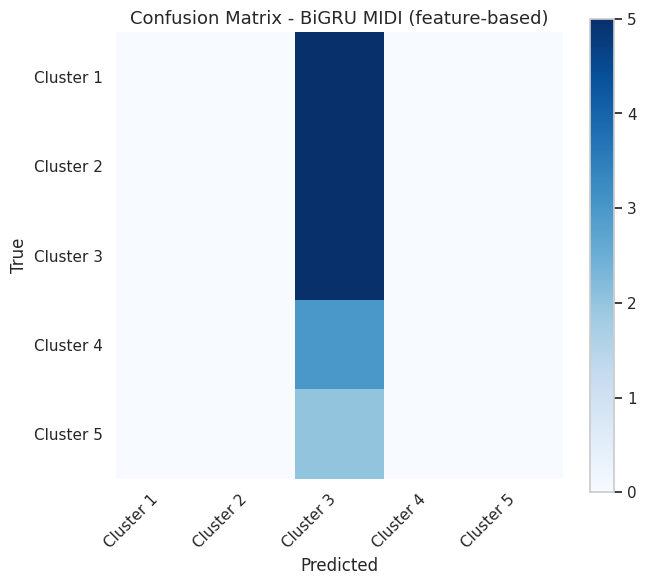

Classification report:
              precision    recall  f1-score   support

   Cluster 1       0.00      0.00      0.00         5
   Cluster 2       0.00      0.00      0.00         5
   Cluster 3       0.25      1.00      0.40         5
   Cluster 4       0.00      0.00      0.00         3
   Cluster 5       0.00      0.00      0.00         2

    accuracy                           0.25        20
   macro avg       0.05      0.20      0.08        20
weighted avg       0.06      0.25      0.10        20



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import torch

state_dict = torch.load(SAVE_DIR / "bigru_midi_features_best.pt", map_location=device)
model.load_state_dict(state_dict)
model.eval()

all_true = []
all_pred = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        logits, _ = model(x)
        preds = logits.argmax(dim=1)

        all_true.extend(y.cpu().numpy())
        all_pred.extend(preds.cpu().numpy())

all_true = np.array(all_true)
all_pred = np.array(all_pred)

cm = confusion_matrix(all_true, all_pred)
print("Confusion matrix:\n", cm)

# ==============================
#   STYLE PUTIH-BIRU
# ==============================
plt.figure(figsize=(7,6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")  # << warna putih-biru
plt.title("Confusion Matrix - BiGRU MIDI (feature-based)", fontsize=13)
plt.colorbar()

tick_marks = np.arange(len(EMOTION_CLASSES))
plt.xticks(tick_marks, EMOTION_CLASSES, rotation=45, ha="right")
plt.yticks(tick_marks, EMOTION_CLASSES)

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)

# Tambah grid tipis
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()

print("Classification report:")
print(classification_report(all_true, all_pred, target_names=EMOTION_CLASSES))

In [29]:
train_df_exp = train_df.copy()
val_df_exp   = val_df.copy()
test_df_exp  = test_df.copy()

train_df_exp["split"] = "train"
val_df_exp["split"]   = "val"
test_df_exp["split"]  = "test"

all_df = pd.concat([train_df_exp, val_df_exp, test_df_exp], ignore_index=True)
all_df = all_df.reset_index(drop=True)

len(all_df), all_df["split"].value_counts()


(194,
 split
 train    155
 test      20
 val       19
 Name: count, dtype: int64)

In [30]:
from torch.utils.data import DataLoader

full_dataset = MidiFeatureDataset(all_df, max_len=MAX_LEN)
full_loader  = DataLoader(full_dataset, batch_size=32, shuffle=False)

probs_list = []
ids_list   = []

model.eval()
with torch.no_grad():
    idx = 0
    for x, y in full_loader:
        batch_size = x.size(0)
        x = x.to(device)
        logits, _ = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        # ambil metadata yang sesuai barisan
        for i in range(batch_size):
            row = all_df.iloc[idx + i]
            ids_list.append({
                "file_id_norm": row["file_id_norm"],
                "emotion": row["emotion"],
                "label_id": row["label_id"],
                "split": row["split"],
                "probs": probs[i]
            })
        idx += batch_size


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [31]:
rows = []
prob_cols = [f"prob_{c}" for c in EMOTION_CLASSES]

for item in ids_list:
    base = {
        "file_id_norm": item["file_id_norm"],
        "emotion": item["emotion"],
        "label_id": item["label_id"],
        "split": item["split"],
    }
    for cls_idx, cls_name in enumerate(EMOTION_CLASSES):
        base[f"prob_{cls_name}"] = float(item["probs"][cls_idx])
    rows.append(base)

probs_df = pd.DataFrame(rows)
probs_path = SAVE_DIR / "midi_bigru_feature_softmax.csv"
probs_df.to_csv(probs_path, index=False)
print("Saved softmax to:", probs_path)
probs_df.head()


Saved softmax to: /content/drive/MyDrive/dataset_mirex/miditrainsvm/midi_bigru_feature_softmax.csv


,file_id_norm,emotion,label_id,split,prob_Cluster 1,prob_Cluster 2,prob_Cluster 3,prob_Cluster 4,prob_Cluster 5
0,019,Cluster 1,0,train,0.219800,0.235197,0.245626,0.170048,0.129328
1,575,Cluster 4,3,train,0.215237,0.236890,0.239378,0.175368,0.133128
2,522,Cluster 3,2,train,0.212781,0.230112,0.256998,0.170813,0.129296
3,301,Cluster 2,1,train,0.220864,0.234828,0.249913,0.167548,0.126847
4,839,Cluster 5,4,train,0.215178,0.233413,0.239951,0.175317,0.136141


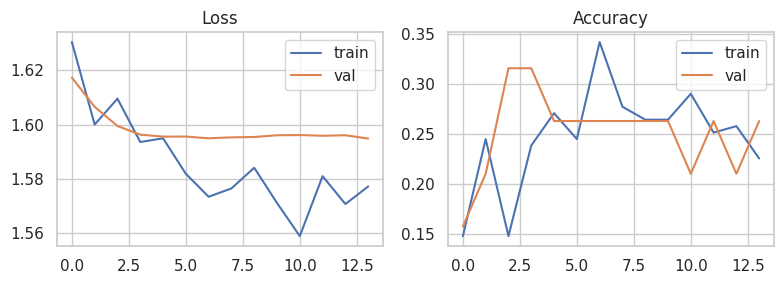

In [32]:
# ===== 12.3 — Plot kurva training/validation =====
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
all_ids = []
all_labels = []
all_splits = []
all_emotions = []

all_probs_bigru = []
all_embeds = []

model.eval()
with torch.no_grad():
    idx = 0
    for x, y in full_loader:
        batch_size = x.size(0)
        x = x.to(device)

        # INI YANG BENAR
        logits, alpha, emb = model(x, return_embedding=True)

        probs = torch.softmax(logits, dim=1).cpu().numpy()
        emb   = emb.cpu().numpy()

        for i in range(batch_size):
            row = all_df.iloc[idx + i]

            all_ids.append(row["file_id_norm"])
            all_labels.append(int(row["label_id"]))
            all_splits.append(row["split"])
            all_emotions.append(row["emotion"])

        all_probs_bigru.append(probs)
        all_embeds.append(emb)

        idx += batch_size

all_probs_bigru = np.vstack(all_probs_bigru)  # (N, 5)
all_embeds      = np.vstack(all_embeds)       # (N, hidden_dim*2)
all_labels      = np.array(all_labels)
all_splits      = np.array(all_splits)


/usr/local/lib/python3.12/dist-packages/pretty_midi/pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [36]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix
)

# Bagi fitur & label
mask_trainval = np.isin(all_splits, ["train", "val"])
mask_test     = (all_splits == "test")

X_train = all_embeds[mask_trainval]
y_train = all_labels[mask_trainval]

X_test  = all_embeds[mask_test]
y_test  = all_labels[mask_test]

# SVM dengan RBF kernel
svm_clf = make_pipeline(
    StandardScaler(),
    SVC(kernel="rbf",
        C=10.0,
        gamma="scale",
        probability=True,
        class_weight="balanced")
)

svm_clf.fit(X_train, y_train)

# Evaluasi di test
y_pred_svm = svm_clf.predict(X_test)
probs_test_svm = svm_clf.predict_proba(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
macro_f1_svm = f1_score(y_test, y_pred_svm, average="macro", zero_division=0)

print("=== SVM on BiGRU embeddings — Test set ===")
print(f"Accuracy : {acc_svm:.4f}")
print(f"Macro F1 : {macro_f1_svm:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_svm, target_names=EMOTION_CLASSES, zero_division=0))

cm_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion matrix:\n", cm_svm)


=== SVM on BiGRU embeddings — Test set ===
Accuracy : 0.1500
Macro F1 : 0.1471

Classification report:
              precision    recall  f1-score   support

   Cluster 1       0.20      0.20      0.20         5
   Cluster 2       0.50      0.20      0.29         5
   Cluster 3       0.33      0.20      0.25         5
   Cluster 4       0.00      0.00      0.00         3
   Cluster 5       0.00      0.00      0.00         2

    accuracy                           0.15        20
   macro avg       0.21      0.12      0.15        20
weighted avg       0.26      0.15      0.18        20


Confusion matrix:
 [[1 1 0 3 0]
 [0 1 1 2 1]
 [1 0 1 1 2]
 [2 0 1 0 0]
 [1 0 0 1 0]]


In [37]:
print("SVM classes_:", svm_clf.named_steps["svc"].classes_)

probs_all_svm = svm_clf.predict_proba(all_embeds)  # (N, num_classes)
probs_all_svm.shape

SVM classes_: [0 1 2 3 4]


(194, 5)

In [39]:
N = len(all_ids)


In [40]:
rows_svm = []

for i in range(N):
    base = {
        "file_id_norm": all_ids[i],
        "emotion": all_emotions[i],
        "label_id": int(all_labels[i]),
        "split": all_splits[i],
    }
    for cls_idx, cls_name in enumerate(EMOTION_CLASSES):
        base[f"prob_{cls_name}"] = float(probs_all_svm[i, cls_idx])
    rows_svm.append(base)

svm_df = pd.DataFrame(rows_svm)
path_svm = SAVE_DIR / "midi_bigru_svm_softmax.csv"
svm_df.to_csv(path_svm, index=False)
print("Saved BiGRU+SVM softmax CSV to:", path_svm)
svm_df.head()


Saved BiGRU+SVM softmax CSV to: /content/drive/MyDrive/dataset_mirex/miditrainsvm/midi_bigru_svm_softmax.csv


,file_id_norm,emotion,label_id,split,prob_Cluster 1,prob_Cluster 2,prob_Cluster 3,prob_Cluster 4,prob_Cluster 5
0,019,Cluster 1,0,train,0.253234,0.255547,0.157697,0.149430,0.184091
1,575,Cluster 4,3,train,0.277998,0.328448,0.128176,0.215475,0.049903
2,522,Cluster 3,2,train,0.184079,0.206025,0.395679,0.155832,0.058384
3,301,Cluster 2,1,train,0.211079,0.247084,0.313805,0.117895,0.110137
4,839,Cluster 5,4,train,0.204348,0.186459,0.185018,0.163354,0.260821
